In [52]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [ ]:
def get_service_time(distribution_type):
    """Generate service time based on the distribution type."""
    if distribution_type == 'deterministic':
        # M/D/n
        return 1 / SERVICE_RATE  
    
    elif distribution_type == 'exponential':
        # M/M/n
        return np.random.exponential(1 / SERVICE_RATE)
    
    elif distribution_type == 'hyperexponential':
        # Service time distribution with long tail
        if np.random.rand() < 0.75:
            return np.random.exponential(1.0)
        else:
            return np.random.exponential(5.0)
    else:
        raise ValueError(f"Unknown distribution type: {distribution_type}")
    

def customer(env, name, server, arrival_rate, wait_times, priority, service_time_distribution):
    """Customer process: arrives, waits in queue, and gets served."""
    arrival_time = env.now
    service_time = get_service_time(service_time_distribution)
    
    if priority:
        with server.request(priority=service_time) as request:
            yield request  # Wait for a free server
            wait_time = env.now - arrival_time
            wait_times.append(wait_time)
            yield env.timeout(service_time)  # Time spent being served

    else:
        with server.request() as request:
            yield request  # Wait for a free server
            wait_time = env.now - arrival_time 
            wait_times.append(wait_time) 
            yield env.timeout(service_time)  # Time spent being served

def arrival_generator(env, server, arrival_rate, wait_times, priority, service_time_distribution):
    """Generate customers arriving at a random Poisson distributed interval with lambda = arrival_rate."""
    while True:
        yield env.timeout(np.random.exponential(1 / arrival_rate))
        env.process(customer(env, f"Customer-{env.now}", server, arrival_rate, wait_times, priority, service_time_distribution))

def simulate(n_servers, arrival_rate, sim_time, priority, service_time_distribution='hyperexponential'):
    """Simulate an M/M/n or M/D/n queue
    Args:
    n_servers (int): number of servers
    arrival_rate (float): avg arrival rate (following exponential distribution)
    sim_time (int): max simulation time
    priority (bool): priority scheduling of the tasks based on service time
    service_time_distribution (str): choose service time distribution: deterministic, exponential, hyperexponential
    
    Returns:
    average wait time in queue (float)
    """
    env = simpy.Environment()
    if priority:
        server = simpy.PriorityResource(env, capacity=n_servers)  # n servers

    else:
        server = simpy.Resource(env, capacity=n_servers)  # n servers

    wait_times = []  # Collect wait times for analysis
    env.process(arrival_generator(env, server, arrival_rate, wait_times, priority, service_time_distribution))
    env.run(until=sim_time)
    return np.mean(wait_times)


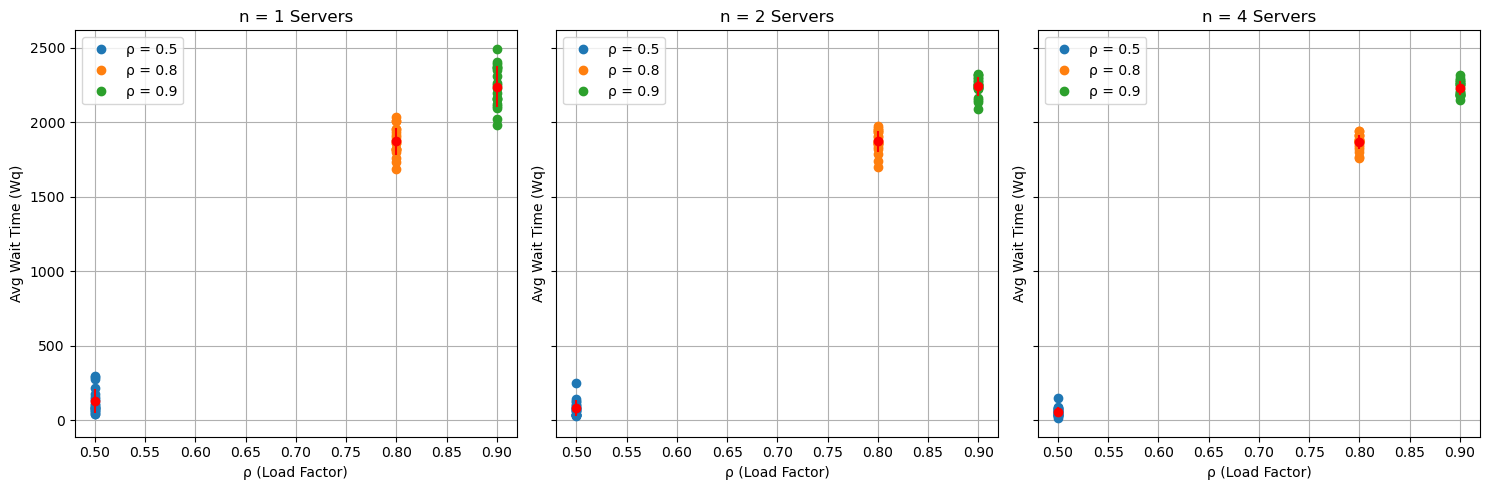

In [54]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
ARRIVAL_RATES = [0.5, 0.8, 0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        # lambda = rho * n *  nu
        # nu = service capacity
        arrival_rate = rho * n_servers * SERVICE_RATE

        for _ in range(n_runs):
            avg_wait = simulate(n_servers, arrival_rate, sim_time, priority=False)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list), figsize=(15, 5), sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, ARRIVAL_RATES, N_RUNS, SIM_TIME)
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in ARRIVAL_RATES:
        avg_waits = results[rho]
        axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


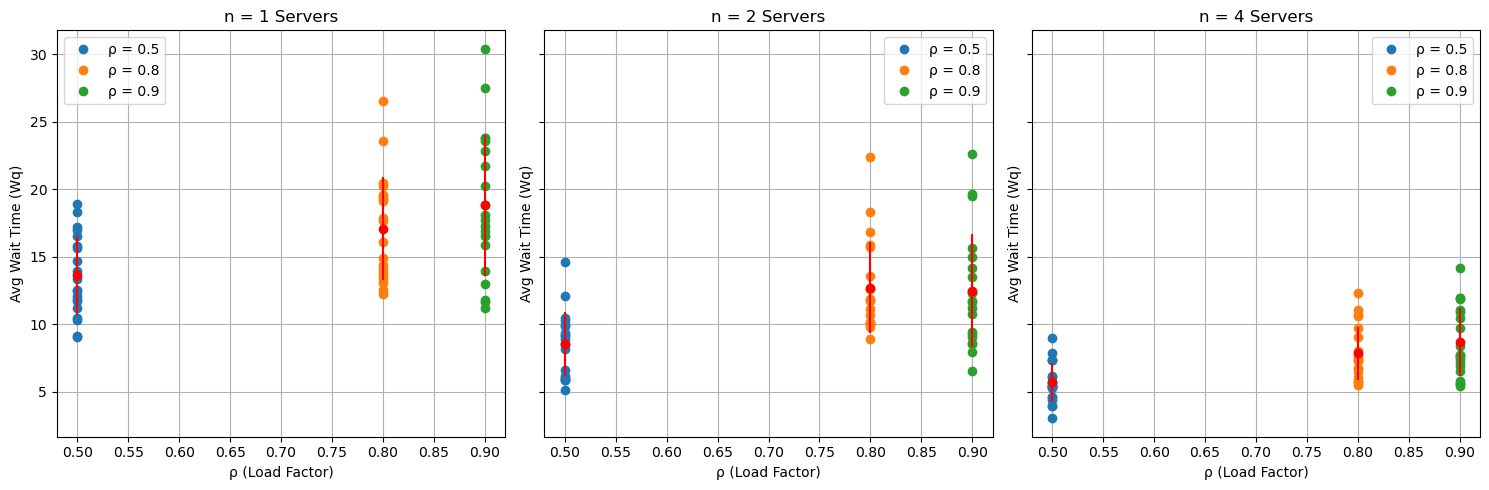

In [55]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
ARRIVAL_RATES = [0.5, 0.8, 0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        arrival_rate = rho * n_servers * SERVICE_RATE
        for _ in range(n_runs):
            avg_wait = simulate(n_servers, arrival_rate, sim_time, priority=True)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list), figsize=(15, 5), sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, ARRIVAL_RATES, N_RUNS, SIM_TIME)
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in ARRIVAL_RATES:
        avg_waits = results[rho]
        axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [56]:
def conduct_t_test(amount_runs=20):
    """
    This function conducts a t test for all combinations of n_servers and ρ values.
    It returns the results of the simulation and the t test.

    :param amount_runs: the amount of runs to conduct for each combination

    :return: results, t_test_results
    """
    # set the seed
    np.random.seed(RANDOM_SEED)

    results = {n: {p: [] for p in ARRIVAL_RATES} for n in n_servers_list}

    # conduct the simulations and save the results
    for n_servers in n_servers_list:
        for i, p in enumerate(ARRIVAL_RATES):
            # get the results for the first p
            for i in range(amount_runs):
                avg_wait = simulate(n_servers, p, SIM_TIME, priority=False)
                results[n_servers][p].append(avg_wait)

    t_test_results = {}
    # conduct the t tests
    for n1 in n_servers_list:
        for n2 in n_servers_list:
            if n1 != n2:
                for p in ARRIVAL_RATES:
                    t_stat, p_value = ttest_ind(results[n1][p], results[n2][p])
                    t_test_results[(n1, n2, p)] = (t_stat, p_value)
                    if p_value < 0.05:
                        print("Significant difference between n={} and n={} for ρ={} with a p_value of {}".format(n1, n2, p, p_value))

    return results, t_test_results

results, t_test_results = conduct_t_test(amount_runs=20)

Significant difference between n=1 and n=2 for ρ=0.5 with a p_value of 1.8352604313199665e-08
Significant difference between n=1 and n=2 for ρ=0.8 with a p_value of 1.3181610300243241e-45
Significant difference between n=1 and n=2 for ρ=0.9 with a p_value of 4.250029387355117e-42
Significant difference between n=1 and n=4 for ρ=0.5 with a p_value of 1.527966283932466e-08
Significant difference between n=1 and n=4 for ρ=0.8 with a p_value of 1.1710031332899223e-45
Significant difference between n=1 and n=4 for ρ=0.9 with a p_value of 3.4041266999359286e-42
Significant difference between n=2 and n=1 for ρ=0.5 with a p_value of 1.8352604313199665e-08
Significant difference between n=2 and n=1 for ρ=0.8 with a p_value of 1.3181610300243241e-45
Significant difference between n=2 and n=1 for ρ=0.9 with a p_value of 4.250029387355117e-42
Significant difference between n=2 and n=4 for ρ=0.5 with a p_value of 1.5286858811505637e-29
Significant difference between n=2 and n=4 for ρ=0.8 with a p_v